In [8]:
#List of imports

import pandas as pd
import scipy.optimize as sco
import numpy as np
import pandas_datareader as web
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as smf
import urllib.request
import zipfile
import cvxpy as cp
from copy import deepcopy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [9]:
def get_mu_Q_multiperiod(exRets, factor_data, lookahead, lookback, regress_type="Linear"):
    """
    exRets: excess return data for stocks
    factor_data: factor return data
    lookahead: number of periods in the future to estimate
    lookback: number of periods in the past to use for estimations
    regress_type: can be 'Linear', 'Lasso', or 'Ridge'
    """
    
    # For keeping track of mu's and Q's from each period
    mu_arr = []
    Q_arr = []
            
    n_factors = len(factor_data.columns)
    factor_data = factor_data.tail(lookback)
    exRets = exRets.tail(lookback)
    factor_data = deepcopy(factor_data)
    
    for i in range(0, lookahead):

        # Calculate the factor covariance matrix
        F = factor_data.loc[:, factor_data.columns != 'Ones'].cov()
        
        # Calculate the factor expected excess return from historical data using the geometric mean
        factor_data.loc[:, 'Ones'] = 1
        gmean = stats.gmean(factor_data + 1,axis=0) - 1

        # Set up X and Y to determine alpha and beta
        X = factor_data
        Y = exRets
        X = X.to_numpy()
        Y = Y.to_numpy()

       # Determine alpha and beta
        if regress_type=="Linear":
            model = LinearRegression().fit(X,Y)
        elif regress_type=="Lasso":
            model = Lasso().fit(X,Y)
        elif regress_type=="Ridge":
            model = Ridge().fit(X,Y)
        else:
            print("Error: This type of regression has not been implemented.")
        alpha = model.intercept_
        beta = model.coef_[:,0:n_factors]

        # Calculate the residuals 
        alpha = np.reshape(alpha,(alpha.size,1))
        epsilon = exRets.to_numpy() - np.matmul(X, np.transpose(np.hstack((beta, alpha))))

        # Calculate the residual variance with "N - p - 1" degrees of freedom
        p = 3
        sigmaEp = np.sum(epsilon**2, axis=0) / (len(exRets) - 1 - p)

        #  Calculate the asset expected excess returns
        mu = model.predict([gmean])[0]

        # Calculate the diagonal matrix of residuals and the asset covariance matrix
        D = np.diag(sigmaEp)

        # Calculate the covariance matrix
        Q = np.matmul(np.matmul(beta,F.to_numpy()),beta.T)+D
        
        # Add mu and Q to array
        mu_arr.append(mu)
        Q_arr.append(Q)
        
        # Update for next time step
        factor_data = factor_data[1:]
        factor_append = pd.Series(gmean, index = factor_data.columns)
        factor_data=factor_data.append(factor_append, ignore_index=True)
        
        exRets = exRets[1:]
        mu_append = pd.Series(mu, index=exRets.columns)
        exRets = exRets.append(mu_append, ignore_index=True)   
        
    return mu_arr, Q_arr

In [14]:
#Set up Data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
data_set= data(price_data,[i for i in range(10)])
data_set.get_stock_returns()
data_set.get_factor_returns()

#Set Up Portfolio
num_stocks=len(data_set.stock_returns.columns)
initial_weights= [1/num_stocks for i in range (num_stocks)]
port= portfolio(initial_weights)


#Set up Backtester
rebal_freq="M"
start_date= "2014-10-31"
end_date= "2019-01-01"
lookback=15
lookahead=5
back_test_ex= backtest(rebal_freq, start_date, end_date, lookback, lookahead)
back_test_ex.run(data_set, port)



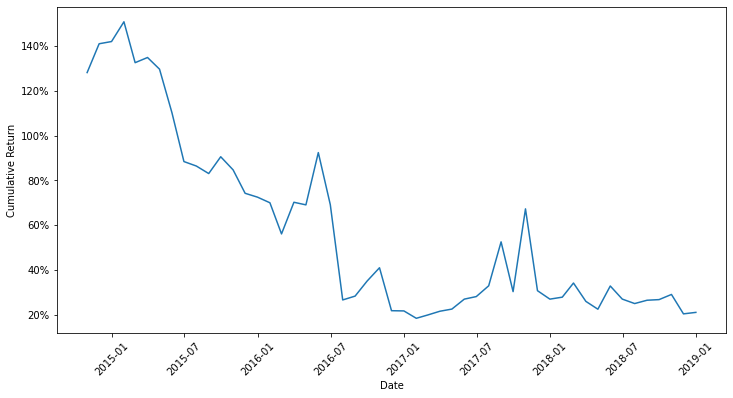

In [256]:
port.plot()

In [117]:
##Main


#Set up Data
price_data = pd.read_csv("../Data/sp500df.csv", index_col='Date')
data_set= data(price_data,[i for i in range(20)])
data_set.get_stock_returns()
data_set.get_factor_returns()

#Set Up Portfolio
num_stocks=len(data_set.stock_returns.columns)
initial_weights= [1/num_stocks for i in range (num_stocks)]
port= portfolio(initial_weights)



#Set Up model
rebal_freq="M"
start_date= "2014-10-31"
end_date= "2017-11-01"
lookback=20
look_ahead=5
lam=0.1
trans_coeff=0.2
holding_coeff=0.2


# upper_asset_limit=np.array([1/num_stocks for i in range(num_stocks)])
# upper_asset_limit=np.tile(upper_asset_limit, (look_ahead,1)).transpose()
# lower_asset_limit=np.array([-1/num_stocks for i in range(num_stocks)])
# lower_asset_limit=np.tile(lower_asset_limit, (look_ahead,1)).transpose()
upper_asset_limit=1
lower_asset_limit=-1
stock_limit=5

constr_model=constraints(upper_asset_limit, lower_asset_limit, stock_limit)
cost_model= costs(trans_coeff, holding_coeff)
cost_model.replicate_cost_coeff(num_stocks, look_ahead)
opt_model=model(look_ahead, lam)



back_test_ex= backtest(rebal_freq, start_date, end_date, lookback, lookahead)
back_test_ex.run(data_set, port, opt_model, constr_model, cost_model)

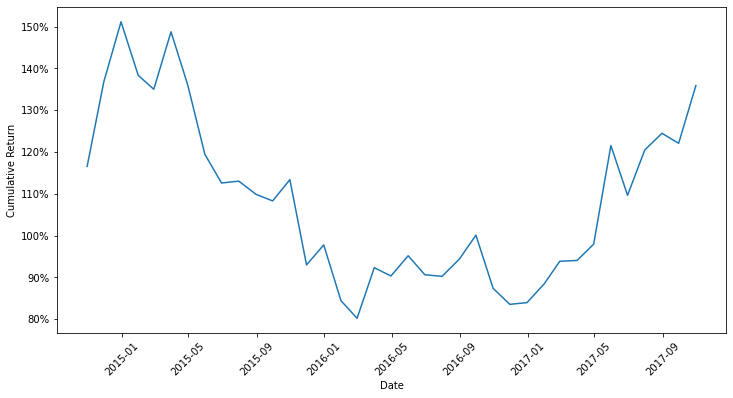

In [118]:
port.plot()

In [106]:
sum(port.weights[0,:])

1.0000000000000002

In [116]:

class data:
    def __init__(self, stock_prices, universe):
        self.factor_returns=None
        self.stock_returns=None
        
        if type(universe[0])== int:
            self.stock_prices=stock_prices.iloc[:,universe]

        else:
            self.stock_prices=stock_prices[universe]
        
        self.stock_prices.index= pd.to_datetime(self.stock_prices.index)

        return
    
    def get_stock_returns(self, period="M"):
        price = self.stock_prices.resample(period).last()

        # Calculate the percent change
        ret_data = price.pct_change()[1:]

        # Convert from series to dataframe
        ret_data = pd.DataFrame(ret_data)

            
        self.stock_returns=ret_data
        return 
    
    def get_factor_returns(self, period="M"):
        ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"    
        # Download the file and save it  
        urllib.request.urlretrieve(ff_url,'fama_french.zip')
        zip_file = zipfile.ZipFile('fama_french.zip', 'r')    
        # Extact the file data
        zip_file.extractall()
        zip_file.close()    
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)   
        # Skip null rows
        ff_row = ff_factors.isnull().any(1).to_numpy().nonzero()[0][0]

        # Read the csv file again with skipped rows
        ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)

        # Format the date index
        ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')

        # Format dates to end of month
        ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()

        # Resample the data to correct frequency
        ff_factors = ff_factors.resample(period).last()

        # Convert from percent to decimal
        ff_factors = ff_factors.apply(lambda x: x/ 100)
        self.factor_returns=ff_factors
        
        return
    
    def get_index_from_date(self, date_index_df, date):

        return date_index_df.index.get_loc(date)
    
    def get_lookback_data(self, date_index_df, date, lookback):
        end_idx= self.get_index_from_date(date_index_df, date)
        return date_index_df.iloc[end_idx-lookback:end_idx]      
     



class portfolio:
    def __init__(self, initial_weights):       
        num_assets=len(initial_weights)
        self.weights= np.array([initial_weights])
        self.returns= np.array([])
        self.dates= []
        
    def update_weights(self, new_weights):
        
        new_weights=np.array([new_weights])        
        self.weights=np.append(self.weights,new_weights,axis=0)
     
    
    def update_returns(self, new_returns):
        self.returns=np.append(self.returns, new_returns)
        
    def update_dates(self, new_dates):
       
        self.dates.append(new_dates)
        
    def plot(self):
        port_cumu_returns = np.array([x+1 for x in self.returns]).cumprod()
        plt.figure(figsize=(12,6))
        plt.plot(self.dates, port_cumu_returns)
        plt.xticks(rotation=45)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
    



class constraints:
        def __init__(self, upper_limit, lower_limit, stock_limit):
            self.upper_limit= upper_limit
            self.lower_limit= lower_limit
            self.stock_limit= stock_limit
            self.value=[]

        
        def weight_unity(self, weights):
            self.value+= [cp.sum(weights,axis=0)==1]
       
        def cardinality(self, y):
            self.value+= [cp.sum(y,axis=0)== self.stock_limit]        
        
        def asset_limit_cardinality(self, y, weights):
            cardinality_upper_limit= cp.multiply(self.upper_limit, y)
            cardinality_lower_limit = cp.multiply(self.lower_limit,y)
            self.value+=  [weights>=cardinality_lower_limit, weights<=cardinality_upper_limit]

        
        def no_short(self, weights):
            self.value+=  [weights>=0]
        
        def asset_limit(self, weights):
            self.value+=  [weights>=self.lower_asset_limit, weights<=self.upper_asset_limit]
        

        

class returns:
    def __init__(self):
        self.value=0
    
    def get_returns(self,mu,weights):          
        portfolio_return_per_period= mu@weights
        portfolio_return= cp.trace(portfolio_return_per_period)
        self.value=portfolio_return
    

class risks:
    def __init__(self):
        self.value=0
    
    def get_var(self, weights, Q, look_ahead):
        portfolio_risk=0
        for i in range(look_ahead):
            portfolio_risk+=cp.quad_form(weights[:,i],Q[i])        
        self.value=portfolio_risk
        
    def get_robust_addon(self, weights, Q, look_ahead, num_stocks):
        robustness_cost=0
        for i in range(look_ahead):
            delta= 1.96*np.sqrt(np.diag(Q[i]/num_stocks))
            robustness_cost+= delta@cp.abs(weights[:,i])
        self.value+= robustness_cost
        

        
        


    

class costs:
    def __init__(self, trans_coeff, holding_coeff):
        self.holding_cost= 0
        self.trans_cost= 0
        self.trans_coeff= trans_coeff
        self.holding_coeff= holding_coeff
        
    def replicate_cost_coeff(self, num_stocks, lookahead):
        trans_cost_repl= np.ones((num_stocks,look_ahead))/100
        holding_cost_repl= np.ones((num_stocks, look_ahead))/100
        self.trans_coeff= trans_cost_repl*self.trans_coeff
        self.holding_coeff= holding_cost_repl*self.holding_coeff
    
    def get_holding_cost(self, weights_new):

        return cp.sum(cp.multiply(self.holding_coeff, cp.neg(weights_new)))
        
    def calc_trans_cost(self, weights_new, weights_old, trans_coeff):
        abs_trade= cp.abs(weights_new-weights_old)
        return cp.sum(cp.multiply(trans_coeff, abs_trade))       
    
    
    def get_trans_cost (self, weights_new,weights_old):
        
        weights_curr= weights_new[:,0]
        if weights_new.shape[1]>1:         
            weights_future= weights_new[:,1:]
            weights_future_shift= weights_new[:,:-1]
            self.trans_cost=self.calc_trans_cost(weights_future, weights_future_shift,self.trans_coeff[:,1:])        
        self.trans_cost+=self.calc_trans_cost( weights_curr, weights_old,self.trans_coeff[:,0])        



class model:
    def __init__(self, look_ahead, lam):
        self.look_ahead= look_ahead
        self.lam=lam
        
    def MVO(self,port, mu ,Q, constraint_model, cost_model):
        
        mu_np =np.array(mu)
        Q_np =np.array(Q)
        num_stocks=port.weights.shape[1]

        #Construct optimization problem
        weights=cp.Variable((num_stocks,look_ahead))
        y= cp.Variable((num_stocks,look_ahead), integer=True)
        
        weights_prev= port.weights[-1,:]      

        cost_model.get_trans_cost(weights, weights_prev)
        cost_model.get_holding_cost(weights)        

        constraint_model.weight_unity(weights)
        constraint_model.no_short(weights)
        constraint_model.cardinality(y)
        constraint_model.asset_limit_cardinality(y, weights)    
        
        return_model=returns()
        return_model.get_returns(mu_np, weights)
        
        risk_model= risks()
        risk_model.get_var(weights, Q, self.look_ahead)
        risk_model.get_robust_addon(weights, Q, self.look_ahead, num_stocks)

        #objective= cp.Maximize(return_model.value - self.lam*risk_model.value - cost_model.trans_cost - cost_model.holding_cost)
        objective= cp.Maximize(return_model.value - self.lam*risk_model.value- cost_model.holding_cost-cost_model.trans_cost)
        #Construct Problem and Solve
        prob= cp.Problem(objective, constraint_model.value)
        result=prob.solve(solver="GUROBI")

       

        return np.array(weights.value)[:,1]
    
    
class backtest:
    def __init__(self,rebal_freq, start_date, end_date, lookback, lookahead):
        self.rebal_freq= rebal_freq
        self.start_date= start_date
        self.end_date= end_date
        self.lookback= lookback
        self.lookahead= lookahead
        self.reb_dates=None
        

    
    def run(self, data, portfolio, optimizer, constr, cost):      
        stock_return= data.stock_returns
        factor_return= data.factor_returns        
        self.reb_dates= np.array(data.stock_returns.loc[self.start_date:self.end_date].index)       
 
        for t in self.reb_dates:

            returns_lookback= data.get_lookback_data(stock_return,t,self.lookback)
            factors_lookback= data.get_lookback_data(factor_return,t,self.lookback)

            mu, Q = get_mu_Q_multiperiod(returns_lookback, factors_lookback, self.lookahead, self.lookback, "Lasso")
#             weights = MVO_Cardinality(mu,Q,self.lookahead,portfolio.weights[-1]) 
            
            
            weights=optimizer.MVO(port, mu ,Q, constr, cost)     
            
            portfolio.update_dates(t)
            portfolio.update_weights(weights)
            portfolio.update_returns(np.dot(weights,stock_return.loc[t]))
            
  






In [9]:
def trans_cost_model(c,weights_old, weights_new):
    abs_trade= cp.abs(weights_new-weights_old)
    return cp.sum(cp.multiply(c, abs_trade))

def hold_cost_model(s, weights_new):
    return cp.sum(cp.multiply(s, cp.neg(weights_new)))
    

def MVO_Cardinality(mu, Q, look_ahead,weights):

    mu_np =np.array(mu)
    num_stocks=mu_np.shape[1]
 
    #Construct optimization problem
    x=cp.Variable((num_stocks,look_ahead))

    x_new= x[:,1:]
    x_old= x[:,:-1]
    
    look_ahead_trades= x_new - x_old
    curr_trade= x[:,0]-weights
    
    trans_cost_coeff= np.ones((num_stocks,look_ahead))/100
    holding_cost_coeff= np.ones((num_stocks, look_ahead))/100
    holding_cost =hold_cost_model(holding_cost_coeff, x)
    trans_cost=trans_cost_model(trans_cost_coeff[:,1:], x_old, x_new)+ trans_cost_coeff[:,0].T@curr_trade

    
    lam=1
    
    y= cp.Variable((num_stocks,look_ahead), integer=True)

    portfolio_return_per_period= mu_np @ x
    
    #Sum Diagnals
    portfolio_return= cp.trace(portfolio_return_per_period)

    portfolio_risk=0
    for i in range(look_ahead):
        portfolio_risk+=cp.quad_form(x[:,i],Q[i])    

    robustness_cost=0
    #find deltas

    objective= cp.Maximize(portfolio_return - lam*portfolio_risk - trans_cost - holding_cost)
    

    #Set Constraints
    #arbritry sizes 
    
    upper_asset_limit=np.array([1/num_stocks for i in range(num_stocks)])
    upper_asset_limit=np.tile(upper_asset_limit, (look_ahead,1)).transpose()
    
    lower_asset_limit=np.array([-1/num_stocks for i in range(num_stocks)])
    lower_asset_limit=np.tile(lower_asset_limit, (look_ahead,1)).transpose()
    
    no_short_condition= [x>=0]
    asset_limit_condition=[x>=lower_asset_limit, x<=upper_asset_limit]
    
    unity_condition= [cp.sum(x,axis=0)==1]
    cardinality_limit=6
    cardinality_condition= [cp.sum(y,axis=0)==cardinality_limit]
    
    cardinality_upper_asset_limit= cp.multiply(upper_asset_limit, y)
    cardinality_lower_asset_limit = cp.multiply(lower_asset_limit,y)
    asset_limit_cardinality_condition=[x>=cardinality_lower_asset_limit, x<=cardinality_upper_asset_limit]
    
    
    constraints= asset_limit_cardinality_condition+ unity_condition

    #Construct Problem and Solve
    prob= cp.Problem(objective, constraints)

    result=prob.solve(solver="GUROBI")



    return np.array(x.value)[:,1]

In [254]:
a=np.array([1,2,3])

In [239]:
np.append(a,5)

array([1, 2, 3, 5])

In [26]:


class test:
    def __init__(self,**kwargs):
        for key,value in kwargs.items():
            print(type(key))
            self.getattr(foo,key)(value)
    def ab(self, i): 
        print(i)
    def cd(self,j):
        print(j)

ModuleNotFoundError: No module named 'foo'

In [27]:
def ab( i): 
    print(i)
def cd(j):
    print(j)

a=test(ab=5, cd=6)

<class 'str'>


AttributeError: 'test' object has no attribute 'key'

In [4]:
a=None
a+[1,2,3]

TypeError: unsupported operand type(s) for +: 'NoneType' and 'list'